In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pydot
import scipy.misc
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')

In [2]:
def load_dataset():
    train_dataset = h5py.File('dataset/train_signs.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    
    test_dataset = h5py.File('dataset/test_signs.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    classes = np.array(test_dataset["list_classes"][:])
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

# 1. Vấn đề của mạng quá sâu
Lợi ích của một very deep network là nó có thể biểu diễn được các chức năng rất phức tạp. Nó cũng có thể tìm hiểu các chức năng ở cấp độ trừu tượng khác nhau, từ các cạnh (ở layer thấp hơn) đến các đặc trưng rất phức tạp (ở các layer sâu hơn). Tuy nhiên việc sử dụng mạng sâu không phải lúc nào cũng hữu ích. Một rào cản lớn đối việc đào tạo chúng là vanishing gradients. Trong quá trình gradient descent, chúng ta backprop từ layer cuối cùng về layer đầu tiên, chúng ta nhân với ma trận trọng số trên mỗi bước, và do đó gradient có thể giảm theo cấp số nhân nhanh chóng đến 0 (hoặc trong trường hợp hiếm hoi tăng theo cấp số nhân nhanh chóng và "explode" để nhận giá trị rất lớn).

# 2. Building a Residual Network
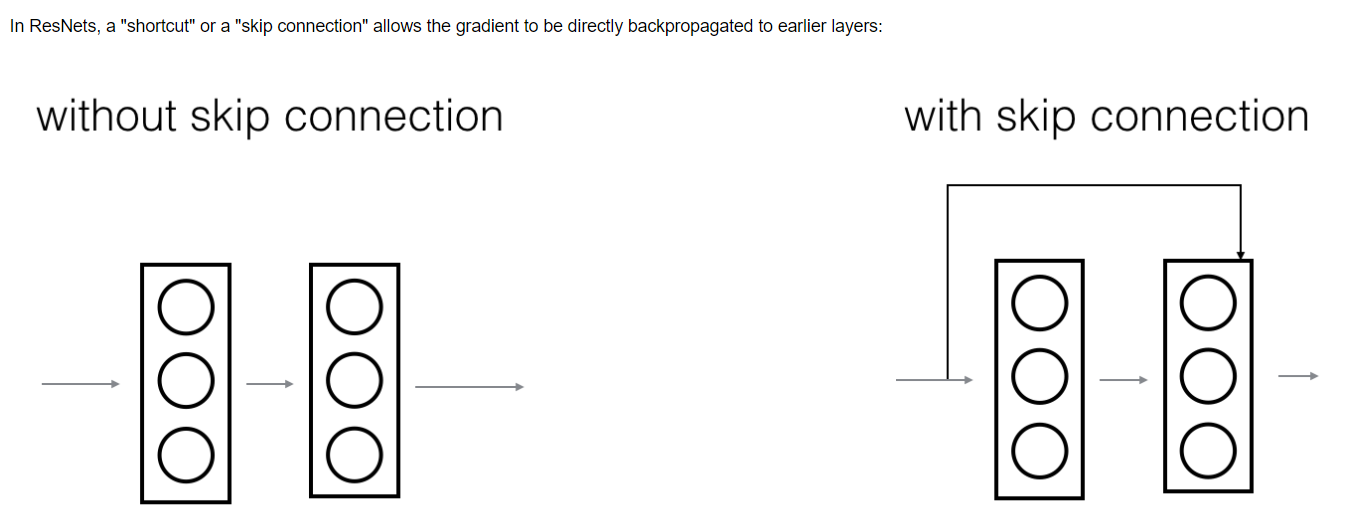


## 2.1 The identity block
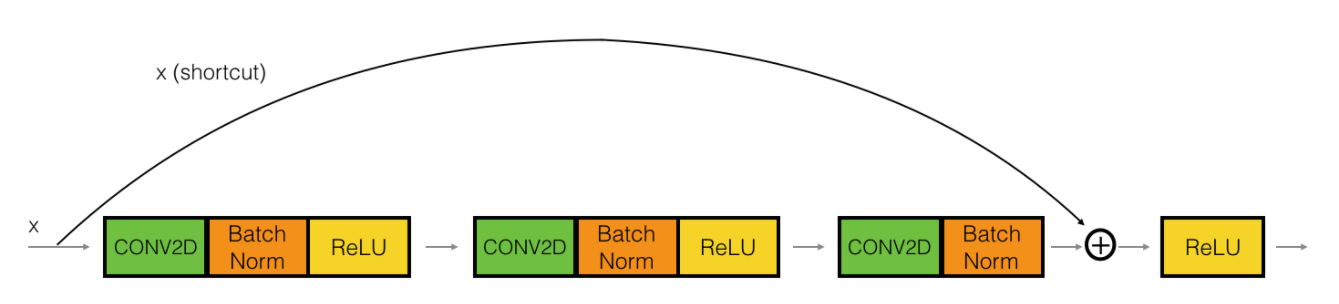

In [4]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure above

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of the main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of the main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## 2.2 The convolutional block
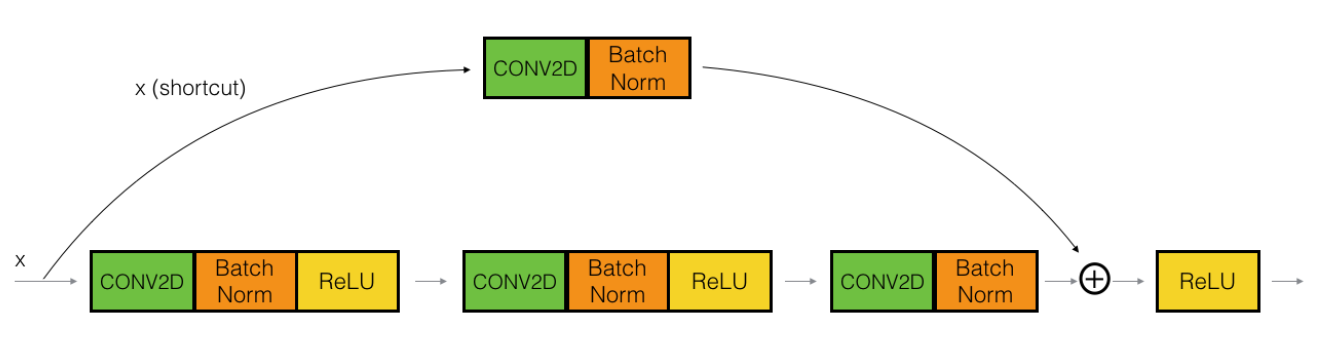

In [5]:
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in figure above 

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path 
    X = Conv2D(F1, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    # Second component of main path
    X = Conv2D(F2, (f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    # Third component of main path
    X = Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    # Shorcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    # Final step
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

# 3. Building ResNet model (50 layers)
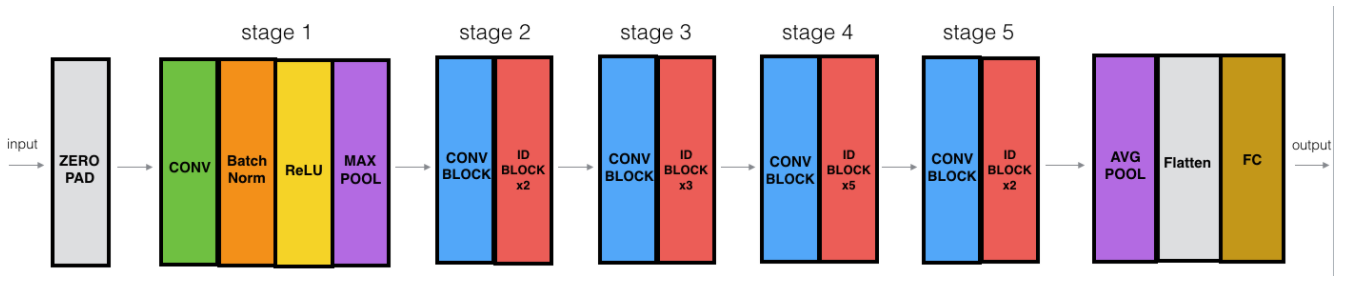

In [6]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2, 2))(X)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block = 'b')
    X = identity_block(X, 3, [64, 64, 256], stage = 2, block = 'c')
    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'b')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'c')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'd')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'e')
    X = identity_block(X, 3, [256, 256, 1024], stage = 4, block = 'f')
    # State 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'b')
    X = identity_block(X, 3, [512, 512, 2048], stage = 5, block = 'c')
    
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(X_input, X, name='ResNet50')
    
    return model

In [7]:
model = ResNet50(input_shape=(64, 64, 3), classes=6)

In [8]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [9]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Data
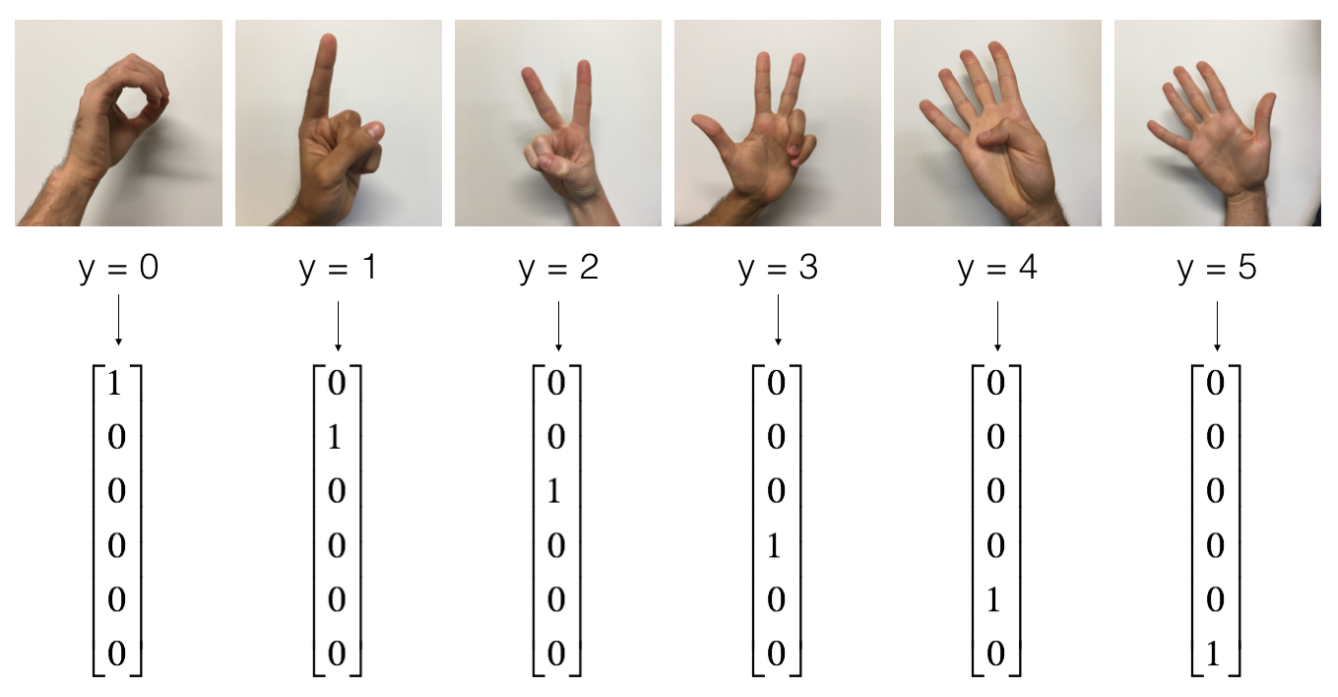

In [10]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = np_utils.to_categorical(Y_train_orig, 6)
Y_test = np_utils.to_categorical(Y_test_orig, 6)
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

Number of training examples = 1080
Number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


In [ ]:
# H = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size = 32)

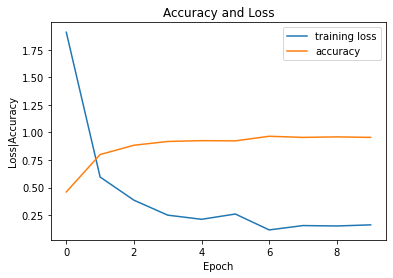

In [22]:
# fig = plt.figure()
# numOfEpoch = 10
# plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
# plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
# plt.plot(np.arange(0, numOfEpoch), H.history['accuracy'], label='accuracy')
# plt.plot(np.arange(0, numOfEpoch), H.history['val_accuracy'], label='validation accuracy')
# plt.title('Accuracy and Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss|Accuracy')
# plt.legend()

In [25]:
preds = model.evaluate(X_test, Y_test)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

4/4 [==============================] - 0s 94ms/step - loss: 5.2735 - accuracy: 0.2583
Loss = 5.273545742034912
Test Accuracy = 0.25833332538604736


In [12]:
model1 = load_model('Signs_weight1.h5')

In [13]:
model1.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [14]:
preds1 = model1.evaluate(X_test, Y_test)
print("Loss = " + str(preds1[0]))
print("Test Accuracy = " + str(preds1[1]))

4/4 [==============================] - 1s 228ms/step - loss: 0.2429 - accuracy: 0.9250
Loss = 0.24288275837898254
Test Accuracy = 0.925000011920929


Giá trị dự đoán:  4


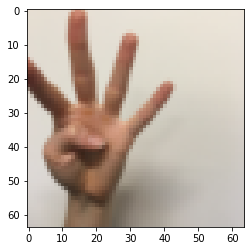

In [18]:
index = 50
plt.imshow(X_test[index])

y_predict = model1.predict(X_test[index].reshape(1,64,64,3))
print('Giá trị dự đoán: ', np.argmax(y_predict))